# Lotka-Volterra Theory

### Continuous-Time Dynamic

$$
\begin{align}
    dr &= (z_1 r - z_2 r f)dt + dn_r \\
    df &= (z_4 r f - z_3 f)dt + dn_f
\end{align}
$$
where:
- $r$: preys
- $f$: predators
- $\{z_1, \ldots, z_4\}$ parameters
- $n_r\sim \mathcal{N}(0, \sigma_r^2)$ and $n_f\sim\mathcal{N}(0, \sigma_f^2)$

### Discretization (Euler-Marayama)

Discretize for $N_s$ time steps of step size $\delta t$ starting from $r_0, f_0$. Given a vector $u_2$ of standard normal variates we do:
- For $s\in\{1, \ldots, N_s\}$:
    - $r_s \longleftarrow r_{s-1} + \delta t(z_1 r_{s-1} - z_2 r_{s-1} f_{s-1}) + \sqrt{\delta t}\sigma_r u_{2, 2s-1}$
    - $f_s \longleftarrow f_{s-1} + \delta t(z_4 r_{s-1} f_{s-1} - z_3 f_{s-1}) + \sqrt{\delta t} \sigma_f u_{2, 2s}$
- Return $x = [r_1, f_1, \ldots, r_{N_s}, f_{N_s}]$

### Extra Details

- $z$ required to be positive, hence put a Log-Normal prior
$$
p_z(z) = \prod_{i=1}^4 \text{LogNormal}(z_i \mid m_i, s_i)
$$
and $z$ can be generated as $z=\exp(s \odot u_1 + m)$ where $s=(s_1, \ldots, s_4)$ and $m = (m_1, \ldots, m_4)$ and $u_1\sim\mathcal{N}(0, I_4)$. In practice use location $m_i=-2$ and scale $s_i=1$.
- $N_s = 50$
- $\delta t = 1$
- $\sigma_r=\sigma_f=1$
- $r_0=f_0=100$
- $z = (0.4, 0.005, 0.05, 0.001)$

Basically I want my input space to be $u = [u_1, u_2]$. Clearly $u_1\in\mathbb{R}^4$ and $u_2\in\mathbb{R}^{2N_s}$, which means overall $u\in\mathbb{R}^{4 + 2N_s}$.

### Jacobian

Let $d=4+2N_s$ be the dimensionality of the input space, and $p=2N_s$ the dimensionality of the output space. Consider $f:\mathbb{R}^{d}\to\mathbb{R}^{p}$ to be the function mapping parameters and latents to the data, i.e. $[z, u_2]\longrightarrow x$ and let its Jacobian be $J_f$. In practice we want to transform $u_1$ to $z$, hence we are interested in the Jacobian $J_h$ of the function $h:\mathbb{R}^d\to\mathbb{R}^{p}$ defined as
$$
h = f \circ g
$$
where $g:\mathbb{R}^d\to\mathbb{R}^{p}$ maps $u_1$ to $z$ and $u_2$ to itself
$$
[u_1, u_2] \longrightarrow [\exp(s\odot u_1 + m), u_2].
$$
By the chain rule for Jacobians one has
$$
    J_h(\xi) = J_{f\circ g}(\xi) = J_f(g(\xi)) J_g(\xi).
$$
The term on the right is easy enough to compute and one has
$$
J_g(\xi) = 
\begin{pmatrix}
    \text{diag}(s \odot \exp(s\odot u_1 + m)) & 0_{4\times p} \\
    0_{p\times 4} & I_{p\times p}
\end{pmatrix} \in\mathbb{R}^{d\times d}
$$
The harder thing to do is to compute $J_f(g(\xi))$.
$$
J_f(g(\xi))
= \begin{pmatrix}
    \partial_{z} r_1 & \partial_{u_2} r_1 \\
    \partial_{z} f_1 & \partial_{u_2} f_1 \\
    \vdots & \vdots \\
    \partial_{z} r_s & \partial_{u_2} r_s \\
    \partial_{z} f_s & \partial_{u_2} f_s \\
    \vdots & \vdots \\
    \partial_{z} r_{N_s} & \partial_{u_2} r_{N_s} \\
    \partial_{z} f_{N_s} & \partial_{u_2} f_{N_s}
\end{pmatrix} \in\mathbb{R}^{p\times d} = \mathbb{R}^{2N_s \times (4 + 2N_s)}
$$

It is therefore important to compute four quantities: $\partial_z r_s$, $\partial_{u_2} r_s$, $\partial_z f_s$ and $\partial_{u_2} f_s$. Given that the updates are
$$
\begin{align}
r_s 
&\longleftarrow r_{s-1} + \delta t(z_1 r_{s-1} - z_2 r_{s-1} f_{s-1}) + \sqrt{\delta t}\sigma_r u_{2, 2s-1} \\
f_s 
&\longleftarrow f_{s-1} + \delta t(z_4 r_{s-1} f_{s-1} - z_3 f_{s-1}) + \sqrt{\delta t} \sigma_f u_{2, 2s}
\end{align}
$$

The derivatives are given by
$$
\begin{align}
    \frac{\partial r_s}{\partial z}
    &= \frac{\partial r_{s-1}}{\partial z} + \delta\left( (1, 0, 0, 0)\frac{\partial r_{s-1}}{\partial z} - (0, 1, 0, 0)\left[\frac{\partial r_{s-1}}{\partial z}f_{s-1} + r_{s-1} \frac{\partial f_{s-1}}{\partial z}\right]\right) \\
    \frac{\partial r_s}{\partial u_2} 
    &= \frac{\partial r_{s-1}}{\partial u_2} + \delta\left(z_1 \frac{\partial r_{s-1}}{\partial u_2} - z_2\left[\frac{\partial r_{s-1}}{\partial u_2} f_{s-1} + r_{s-1}\frac{\partial f_{s-1}}{\partial u_2}\right]\right) + \sqrt{\delta}\sigma_r \mathbb{1}_{p}(2s-1) \\
    \frac{\partial f_s}{\partial z}
    &= \frac{\partial f_{s-1}}{\partial z} + \delta\left((0,0,0,1)\left[\frac{\partial r_{s-1}}{\partial z}f_{s-1} + r_{s-1}\frac{\partial f_{s-1}}{\partial z}\right] - (0,0,1,0)\frac{\partial f_{s-1}}{\partial z}\right) \\
    \frac{\partial f_s}{\partial u_2}
    &= \frac{\partial f_{s-1}}{\partial u_2} + \delta\left(z_4\left[\frac{\partial r_{s-1}}{\partial u_2}f_{s-1} + r_{s-1}\frac{\partial f_{s-1}}{\partial u_2}\right] - z_3 \frac{\partial f_{s-1}}{\partial u_2}\right) + \sqrt{\delta}\sigma_f\mathbb{1}_p(2s)
\end{align}
$$

These can actually be condensed into rows as follows (here we use $\xi=[z, u_2]$):
$$
\begin{align}
        \frac{\partial r_s}{\partial \xi} 
        &= \frac{\partial r_{s-1}}{\partial \xi} + \delta\left(\mathbb{1}_{d}(1)r_{s-1} + z_1 \frac{\partial r_{s-1}}{\partial \xi} - \left[\mathbb{1}_d(2) r_{s-1} f_{s-1} + z_2 \frac{\partial r_{s-1}}{\partial \xi}f_{s-1} + z_2 r_{s-1}\frac{\partial f_{s-1}}{\partial \xi}\right]\right) + \sqrt{\delta}\sigma_r \mathbb{1}_{d}(4 + 2s - 1) \\
        \frac{\partial f_s}{\partial \xi} 
        &= \frac{\partial f_{s-1}}{\partial \xi} + \delta\left(\left[\mathbb{1}_d(4) r_{s-1}f_{s-1} + z_4 \frac{\partial r_{s-1}}{\partial \xi}f_{s-1} + z_4 r_{s-1}\frac{\partial f_{s-1}}{\partial \xi}\right] - \mathbb{1}_d(3)f_{s-1} - z_3 \frac{\partial f_{s-1}}{\partial \xi}\right) + \sqrt{\delta}\sigma_f \mathbb{1}_d(4 + 2s)
\end{align}
$$

In [1]:
import numpy as np
from numpy import eye, zeros, ones, exp, sqrt, log, r_, concatenate, diag, pi
from numpy.linalg import norm
from numpy.random import randn 
from numpy.random import default_rng
from scipy.linalg import block_diag
from scipy.optimize import fsolve
from scipy.stats import multivariate_normal as MVN

from warnings import catch_warnings, filterwarnings, resetwarnings

import matplotlib.pyplot as plt
from matplotlib import rc

from autograd import jacobian, grad
import autograd.numpy as anp

from tangential_hug_functions import HugTangentialMultivariateSafe
from RWM import RWM
from Manifolds.Manifold import Manifold
from utils import ESS_univariate

import math
from scipy.linalg import qr
import scipy.linalg as la
from numpy.random import rand
from numpy.linalg import solve
import time
import pandas as pd
from arviz import convert_to_dataset
from arviz import ess as ess_arviz

from copy import deepcopy

In [2]:
def compute_arviz_miness_runtime(chains, times):
    """Computes minESS/runtime. Expects chains=[samples, samples, ...] and times = [time, time, ...]."""
    assert np.all([chain.shape == chains[0].shape for chain in chains]), "Chains must have same dimensions."
    n_samples = len(chains[0])
    stacked = np.vstack([chain.reshape(1, n_samples, -1) for chain in chains])
    dataset = convert_to_dataset(stacked)
    return min(np.array(ess_arviz(dataset).to_array()).flatten()) / np.mean(times)

In [3]:
_ = compute_arviz_miness_runtime([randn(4, 3), randn(4, 3)], [1, 1])

In [4]:
z_true = (0.4, 0.005, 0.05, 0.001)

In [3]:
# def z_to_u1(z, m=-2*ones(4), s=ones(4)):
#     """Transforms a parameter z into u1 (standard normal variables)."""
#     return (log(z) - m) / s

# def u1_to_z(u1, m=-2*ones(4), s=ones(4)):
#     """Given u1, it maps it to z."""
#     assert len(u1) == 4, "u1 should have length 4, but found {}".format(len(u1))
#     return exp(s*u1 + m)

# def g(u):
#     """Takes [u1, u2] and returns [z, u2]"""
#     return r_[u1_to_z(u[:4]), u[4:]]
    
# def zu2_to_x(zu2):
#     """Same as u_to_x but this takes as input [z, u2]."""
#     z1, z2, z3, z4 = zu2[:4]
#     u2 = zu2[4:]
#     u2_r = u2[::2]
#     u2_f = u2[1::2]
#     r = np.full(Ns + 1, fill_value=np.nan)
#     f = np.full(Ns + 1, fill_value=np.nan)
#     r[0] = r0
#     f[0] = f0
#     for s in range(1, Ns+1):
#         r[s] = r[s-1] + δ*(z1*r[s-1] - z2*r[s-1]*f[s-1]) + sqrt(δ)*σr*u2_r[s-1]
#         f[s] = f[s-1] + δ*(z4*r[s-1]*f[s-1] - z3*f[s-1]) + sqrt(δ)*σf*u2_f[s-1]
#     return np.ravel([r[1:], f[1:]], 'F')
    

# def u_to_x(u, r0=100, f0=100, Ns=50, δ=1, σr=1, σf=1):
#     """Maps u=[u1, u2] to z."""
#     u1, u2 = u[:4], u[4:]
#     u2_r   = u2[::2]
#     u2_f   = u2[1::2]
#     z1, z2, z3, z4 = u1_to_z(u1)
#     r = np.full(Ns + 1, fill_value=np.nan)
#     f = np.full(Ns + 1, fill_value=np.nan)
#     r[0] = r0
#     f[0] = f0
#     for s in range(1, Ns+1):
#         r[s] = r[s-1] + δ*(z1*r[s-1] - z2*r[s-1]*f[s-1]) + sqrt(δ)*σr*u2_r[s-1]
#         f[s] = f[s-1] + δ*(z4*r[s-1]*f[s-1] - z3*f[s-1]) + sqrt(δ)*σf*u2_f[s-1]
#     return np.ravel([r[1:], f[1:]], 'F')

# def Jg(ξ):
#     """Jacobian of the function g:[u_1, u_2] --> [z, u_2]."""
#     m = -2*ones(4)
#     s = ones(4)
#     return diag(r_[s*exp(s*ξ[:4] + m), ones(2*Ns)])

# def oneat(ix, length=(2*Ns + 4)):
#     """Generates a vector of zeros of length `length` with a one at index ix."""
#     output = zeros(length)
#     output[ix] = 1
#     return output

# def Jf(ξ, return_data=False):
#     """Jacobian of the function f:[z, u_2] --> x.
#     Assume r and f contains r0 and f0 at the start."""
#     J = zeros((2*Ns, 4 + 2*Ns))
#     # Sete first two rows: dr1_dξ and df1_dξ
#     J[0, :] = np.concatenate(([δ*r0, -δ*r0*f0, 0, 0], sqrt(δ)*σr*oneat(0, length=2*Ns)))
#     J[1, :] = np.concatenate(([0, 0, -δ*f0, δ*r0*f0], sqrt(δ)*σf*oneat(1, length=2*Ns)))
#     # Evaluate function at the ξ to find r and f at this ξ.
#     x = zu2_to_x(ξ)
#     r = np.concatenate(([r0], x[::2]))
#     f = np.concatenate(([f0], x[1::2]))
#     # Grab the parameters
#     z1, z2, z3, z4 = ξ[:4]
#     # Loops through the time steps and compute the Markovian rows
#     for s in range(1, Ns):
#         J[2*s, :]     = J[2*s-2, :] + δ*(oneat(0)*r[s] + z1*J[2*s-2, :] -(oneat(1)*r[s]*f[s] + z2*J[2*s-2, :]*f[s] + z2*r[s]*J[2*s-1, :])) + sqrt(δ)*σr*oneat(2*s+4)
#         J[2*s + 1, :] = J[2*s-1, :] + δ*(oneat(3)*r[s]*f[s] + z4*J[2*s-2, :]*f[s] + z4*r[s]*J[2*s-1, :] - oneat(2)*f[s] - z3*J[2*s-1, :]) + sqrt(δ)*σf*oneat(2*s+5)
#     if return_data:
#         return J, x
#     else:
#         return J
    
# def J(u):
#     """Total jacobian. Here u=[u1, u2]."""
#     return Jf(g(u)) @ Jg(u)

# def constraint(u):
#     """Constraint function taking u=[u1, u2] and comparing against true data."""
#     return u_to_x(u) - data

In [4]:
# Ns = 50
# d = 2*Ns + 4

In [5]:
# u_true = r_[z_to_u1(z_true), randn(2*Ns)]

In [6]:
# data = u_to_x(u_true)

In [7]:
# rc('font',**{'family':'STIXGeneral'})
# fig, ax = plt.subplots()
# ax.plot(data[::2], label='Preys')
# ax.plot(data[1::2], label='Predators')
# plt.legend()
# plt.show()

In [8]:
# def find_point_on_manifold(data, Ns=50, maxiter=2000, tol=1e-14):
#     """Finds a point on the Manifold with input u=[u1, u2]."""
#     constraint = lambda ξ: u_to_x(ξ, Ns=Ns) - data
#     i = 0
#     with catch_warnings():
#         filterwarnings('error')
#         while i <= maxiter:
#             i += 1
#             try:
#                 u1_init  = randn(4)*0.1 - 4 #u_true[:4] #randn(4)*0.1 - 4
#                 u2_guess = zeros(2*Ns) #randn(2*Ns)
#                 function = lambda u2: constraint(np.concatenate((u1_init, u2)))
#                 u2_found = fsolve(function, u2_guess, xtol=tol)
#                 u_found = np.concatenate((u1_init, u2_found))
#                 return u_found
#             except RuntimeWarning:
#                 continue
#         raise ValueError("Couldn't find a point, try again.")
        
# def find_point_on_manifold_given_u1(u1, data, Ns=50, maxiter=2000, tol=1e-14):
#     """Finds a point on the Manifold with input u=[u1, u2]."""
#     constraint = lambda ξ: u_to_x(ξ, Ns=Ns) - data
#     i = 0
#     with catch_warnings():
#         filterwarnings('error')
#         while i <= maxiter:
#             i += 1
#             try:
#                 u2_guess = zeros(2*Ns)  # randn(2*Ns)
#                 function = lambda u2: constraint(np.concatenate((u1, u2)))
#                 u2_found = fsolve(function, u2_guess, xtol=tol)
#                 u_found = np.concatenate((u1, u2_found))
#                 return u_found
#             except RuntimeWarning:
#                 continue
#         raise ValueError("Couldn't find a point, try again.")

In [9]:
# def transform_usamples_to_zsamples(samples):
#     """Given samples of size (N, 4 + 2*Ns) it takes the first 4 columns and transforms them."""
#     n_samples, input_dim = samples.shape
#     assert samples.shape[1] == 4 + 2*Ns, "Wrong dim.".format(4 + 2*Ns, samples.shape[1])
#     return np.apply_along_axis(u1_to_z, 1, samples[:, :4])

In [10]:
# u0 = find_point_on_manifold(tol=1e-15)

In [11]:
# u0_with_u1true = find_point_on_manifold_given_u1(z_to_u1(z_true), tol=1e-15)

In [12]:
# q = MVN(zeros(d), eye(d))

In [13]:
# def log_normal_kernel(ξ, ϵ):
#     """Log normal kernel density."""
#     u = norm(constraint(ξ))   ##### THIS IS NOT THE USUAL u
#     return -u**2/(2*(ϵ**2)) -0.5*log(2*pi*(ϵ**2))

# def generate_logpi(ϵ):
#     """Generates ABC posterior using a certain epsilon value. Uses a Gaussian kernel. """
#     logηϵ = lambda ξ: log_normal_kernel(ξ, ϵ) - ξ@ξ/2
#     return logηϵ

In [14]:
# N = 20000
# T = 0.3
# B = 5

#### C-RWM

In [30]:
class LVManifold(Manifold):
    def __init__(self, Ns=50, step_size=1.0, σr=1, σf=1, r0=100, f0=100, z_true=(0.4, 0.005, 0.05, 0.001), seed=1111):
        self.Ns = Ns              # Number of steps used in integrating LV SDE
        self.m = 2*self.Ns        # Number of constraints = dimensionality of data
        self.d = 4                # Dimensionality of parameter
        self.n = self.d + self.m  # Dimensionality of ambient space
        self.δ = step_size        # Step size for discretization (not for sampling!)
        self.σr = σr              # Scale for noise in prey step
        self.σf = σf              # Scale for noise in predator step
        self.r0 = r0              # Initial prey population
        self.f0 = f0              # Initial predator population
        self.z_true = np.array(z_true)  # True parameter
        self.q_dist = MVN(zeros(self.n), eye(self.n))   # proposal for THUG
        # generate data
        self.random_seed = seed
        self.rng = default_rng(self.random_seed)
        self.u1_true = self.z_to_u1(self.z_true)
        self.u2_true = self.rng.normal(loc=0.0, scale=1.0, size=2*self.Ns)
        self.u_true = np.concatenate((self.u1_true, self.u2_true))
        self.ystar  = self.u_to_x(self.u_true)
        
    def z_to_u1(self, z):
        """Transforms a parameter z into u1 (standard normal variables)."""
        assert len(z) == 4, "z should have length 4, but found {}".format(len(z))
        m_param = -2*ones(4)
        s_param = ones(4)
        return (log(z) - m_param) / s_param
    
    def u1_to_z(self, u1):
        """Given u1, it maps it to z."""
        assert len(u1) == 4, "u1 should have length 4, but found {}".format(len(u1))
        m_param = -2*ones(4)
        s_param = ones(4)
        return exp(s_param*u1 + m_param)
    
    def g(self, u):
        """Takes [u1, u2] and returns [z, u2]"""
        assert len(u) == self.n, "u should have length {}, but found {}".format(self.n, len(u))
        return np.concatenate((self.u1_to_z(u[:4]), u[4:]))
    
    def u_to_x(self, u):
        """Maps u=[u1, u2] to z."""
        assert len(u) == self.n, "u should have length {}, but found {}.".format(self.n, len(u))
        u1, u2 = u[:4], u[4:]
        u2_r   = u2[::2]
        u2_f   = u2[1::2]
        z1, z2, z3, z4 = self.u1_to_z(u1)
        r = np.full(self.Ns + 1, fill_value=np.nan)
        f = np.full(self.Ns + 1, fill_value=np.nan)
        r[0] = self.r0
        f[0] = self.f0
        for s in range(1, self.Ns+1):
            r[s] = r[s-1] + self.δ*(z1*r[s-1] - z2*r[s-1]*f[s-1]) + sqrt(self.δ)*self.σr*u2_r[s-1]
            f[s] = f[s-1] + self.δ*(z4*r[s-1]*f[s-1] - z3*f[s-1]) + sqrt(self.δ)*self.σf*u2_f[s-1]
        return np.ravel([r[1:], f[1:]], 'F')
    
    def zu2_to_x(self, zu2):
        """Same as u_to_x but this takes as input [z, u2]."""
        assert len(zu2) == self.n, "zu2 should have length {}, but found {}".format(self.n, len(zu2))
        z1, z2, z3, z4 = zu2[:4]
        u2 = zu2[4:]
        u2_r = u2[::2]
        u2_f = u2[1::2]
        r = np.full(self.Ns + 1, fill_value=np.nan)
        f = np.full(self.Ns + 1, fill_value=np.nan)
        r[0] = self.r0
        f[0] = self.f0
        for s in range(1, self.Ns+1):
            r[s] = r[s-1] + self.δ*(z1*r[s-1] - z2*r[s-1]*f[s-1]) + sqrt(self.δ)*self.σr*u2_r[s-1]
            f[s] = f[s-1] + self.δ*(z4*r[s-1]*f[s-1] - z3*f[s-1]) + sqrt(self.δ)*self.σf*u2_f[s-1]
        return np.ravel([r[1:], f[1:]], 'F')
    
    def Jg(self, ξ):
        """Jacobian of the function g:[u_1, u_2] --> [z, u_2]."""
        assert len(ξ) == self.n, "ξ should have length {}, but found {}.".format(self.n, len(ξ))
        m_param = -2*ones(4)
        s_param = ones(4)
        return diag(np.concatenate((s_param*exp(s_param*ξ[:4] + m_param), ones(2*self.Ns))))
    
    def oneat(self, ix, length=None):
        """Generates a vector of zeros of length `length` with a one at index ix."""
        assert type(ix) == int, "index for oneat() should be integer but found {}".format(type(ix))
        if length is None:
            length = self.n
        output = zeros(length)
        output[ix] = 1
        return output
    
    def Jf(self, ξ):
        """Jacobian of the function f:[z, u_2] --> x.
        Assume r and f contains r0 and f0 at the start."""
        assert len(ξ) == self.n, "ξ should have length {}, but found {}.".format(self.n, len(ξ))
        J = zeros((self.m, self.n))
        δ  = self.δ
        r0 = self.r0
        f0 = self.f0 
        σr = self.σr
        σf = self.σf
        # Sete first two rows: dr1_dξ and df1_dξ
        J[0, :] = np.concatenate(([δ*r0, -δ*r0*f0, 0, 0], sqrt(δ)*σr*self.oneat(0, length=self.m)))
        J[1, :] = np.concatenate(([0, 0, -δ*f0, δ*r0*f0], sqrt(δ)*σf*self.oneat(1, length=self.m)))
        # Evaluate function at the ξ to find r and f at this ξ.
        x = self.zu2_to_x(ξ)
        r = np.concatenate(([r0], x[::2]))
        f = np.concatenate(([f0], x[1::2]))
        # Grab the parameters
        z1, z2, z3, z4 = ξ[:4]
        # Loops through the time steps and compute the Markovian rows
        for s in range(1, self.Ns):
            J[2*s, :]     = J[2*s-2, :] + δ*(self.oneat(0)*r[s] + z1*J[2*s-2, :] -(self.oneat(1)*r[s]*f[s] + z2*J[2*s-2, :]*f[s] + z2*r[s]*J[2*s-1, :])) + sqrt(δ)*σr*self.oneat(2*s+4)
            J[2*s + 1, :] = J[2*s-1, :] + δ*(self.oneat(3)*r[s]*f[s] + z4*J[2*s-2, :]*f[s] + z4*r[s]*J[2*s-1, :] - self.oneat(2)*f[s] - z3*J[2*s-1, :]) + sqrt(δ)*σf*self.oneat(2*s+5)
        return J

    def q(self, ξ):
        """Constraint function taking u=[u1, u2] and comparing against true data."""
        assert len(ξ) == self.n, "ξ should have length {}, but found {}.".format(self.n, len(ξ))
        return self.u_to_x(ξ) - self.ystar
    
    def J(self, ξ):
        """Jacobian. Here u=[u1, u2]."""
        assert len(ξ) == self.n, "ξ should have length {}, but found {}.".format(self.n, len(ξ))
        return self.Jf(self.g(ξ)).dot(self.Jg(ξ))
    
    def Q(self, ξ):
        """Transpose of Jacobian."""
        assert len(ξ) == self.n, "ξ should have length {}, but found {}.".format(self.n, len(ξ))
        return self.J(ξ).T
    
    def logη(self, ξ):
        """Density on Manifold wrt Hausdorff measure."""
        assert len(ξ) == self.n, "ξ should have length {}, but found {}.".format(self.n, len(ξ))
        try:
            J = self.J(ξ)
            logprior = -ξ@ξ/2
            correction_term  = - math.prod(np.linalg.slogdet(J@J.T))/2 
            return  logprior + correction_term
        except ValueError as e:
            return -np.inf
        
    def find_point_on_manifold(self, maxiter=2000, tol=1e-14, random_u2_guess=False):
        """Finds a point on the Manifold with input u=[u1, u2]."""
        u2_guess = randn(self.m) if random_u2_guess else zeros(self.m)
        i = 0
        with catch_warnings():
            filterwarnings('error')
            while i <= maxiter:
                i += 1
                try: 
                    u1_init  = randn(self.d)*0.1 - 4
                    function = lambda u2: self.q(np.concatenate((u1_init, u2)))
                    fprime   = lambda u2: self.J(np.concatenate((u1_init, u2)))[:, self.d:]
                    u2_found = fsolve(function, u2_guess, xtol=tol, fprime=fprime)
                    u_found = np.concatenate((u1_init, u2_found))
                    return u_found
                except RuntimeWarning:
                    continue
        raise ValueError("Couldn't find a point, try again.")
        
    def find_point_on_manifold_given_u1true(self, maxiter=2000, tol=1e-14, random_u2_guess=False):
        """Finds a point on the Manifold starting from u1_true."""
        i = 0
        with catch_warnings():
            filterwarnings('error')
            while i <= maxiter:
                i += 1
                try:
                    u2_guess = randn(self.m) if random_u2_guess else zeros(self.m)
                    function = lambda u2: self.q(np.concatenate((self.u1_true, u2)))
                    u2_found = fsolve(function, u2_guess, xtol=tol)
                    u_found = np.concatenate((self.u1_true, u2_found))
                    return u_found
                except RuntimeWarning:
                    continue
        raise ValueError("Couldn't find a point, try again.")
            
    def transform_usamples_to_zsamples(self, samples):
        """Given samples of size (N, 4 + 2*Ns) it takes the first 4 columns and transforms them."""
        n_samples, input_dim = samples.shape
        assert input_dim == self.n, "Wrong dim. Expected {} , found {}".format(self.n, input_dim)
        return np.apply_along_axis(self.u1_to_z, 1, samples[:, :4])
    
    def log_normal_kernel(self, ξ, ϵ):
        """Log normal kernel density."""
        assert len(ξ) == self.n, "ξ should have length {}, but found {}.".format(self.n, len(ξ))
        u = norm(self.q(ξ))   ##### THIS IS NOT THE USUAL u
        return -u**2/(2*(ϵ**2)) -0.5*log(2*pi*(ϵ**2))

    def generate_logpi(self, ϵ):
        """Generates ABC posterior using a certain epsilon value. Uses a Gaussian kernel. """
        logηϵ = lambda ξ: self.log_normal_kernel(ξ, ϵ) - ξ@ξ/2
        return logηϵ
    
    def is_on_manifold(self, ξ, tol=1e-14):
        """Checks if a point is on the manifold."""
        return max(abs(self.q(ξ))) <= tol

In [6]:
def zappa_sampling_storecomps_rattle(x0, manifold, n, T, B, tol, rev_tol, maxiter=50, norm_ord=2):
    """C-RWM Rattle."""
    assert type(B) == int, "B should be int, but found {}".format(type(B))
    assert norm_ord in [2, np.inf], "Invalid norm provided."
    assert len(x0) == manifold.n, "Initial point has wrong dimension."
    # Check arguments
    n = int(n)   # Number of samples
    B = int(B)   # Number of leapfrog steps
    δ = T / B    # Step size
    d, m = manifold.get_dimension(), manifold.get_codimension()   # Here d should be manifold.n, and m manifold.m 

    # Initial point on the manifold
    x = x0
    compute_J = manifold.J

    # House-keeping
    samples = zeros((n, d + m))    # Store n samples on the manifold
    samples[0, :] = x
    i = 1
    N_EVALS = {'jacobian': 0, 'density': 0}
    ACCEPTED = zeros(n)
    # Define function to compute density
    def logη(x):
        """Computes log density on Manifold but makes sure everything is behaving nicely."""
        return manifold.logη(x)

    # Log-uniforms for MH accept-reject step
    logu = log(rand(n))

    # Compute jacobian & density value
    Jx    = compute_J(x) #manifold.Q(x).T
    logηx = logη(x)
    N_EVALS['jacobian'] += 1
    N_EVALS['density'] += 1

    # Function to project onto tangent space
    def qr_project(v, J):
        """Projects using QR decomposition."""
        Q, _ = qr(J.T, mode='economic')
        return Q @ (Q.T @ v)
    
    def linear_project(v, J):
        """Projects by solving linear system."""
        return J.T @ solve(J@J.T, J@v)

    # Constrained Step Function
    def constrained_rwm_step(x, v, tol, maxiter, Jx, norm_ord=norm_ord):
        """Used for both forward and backward. See Manifold-Lifting paper."""
        # Project momentum
        v_projected = v - linear_project(v, Jx) 
        # Unconstrained position step
        x_unconstr = x + v_projected
        # Position Projection
        a, flag, n_grad = project_zappa(manifold, x_unconstr, Jx.T, tol, maxiter, norm_ord=norm_ord)
        y = x_unconstr - Jx.T @ a 
        try:
            Jy = compute_J(y) 
        except ValueError as e:
            print("Jacobian computation at projected point failed. ", e)
            return x, v, Jx, 0, n_grad + 1
        # backward velocity
        v_would_have = y - x
        # Find backward momentum & project it to tangent space at new position
        v_projected_endposition = v_would_have - linear_project(v_would_have, Jy) #qr_project(v_would_have, Jy) #qr_project((y - x) / δ, Jy)
        # Return projected position, projected momentum and flag
        return y, v_projected_endposition, Jy, flag, n_grad + 1
    
    def constrained_leapfrog(x0, v0, J0, B, tol, rev_tol, maxiter, norm_ord=norm_ord):
        """Constrained Leapfrog/RATTLE."""
        successful = True
        n_jacobian_evaluations = 0
        x, v, J = x0, v0, J0
        for _ in range(B):
            xf, vf, Jf, converged_fw, n_fw = constrained_rwm_step(x, v, tol, maxiter, J, norm_ord=norm_ord)
            xr, vr , Jr, converged_bw, n_bw = constrained_rwm_step(xf, -vf, tol, maxiter, Jf, norm_ord=norm_ord)
            n_jacobian_evaluations += (n_fw + n_bw)  # +2 due to the line Jy = manifold.Q(y).T
#             print("\t\tLeapfrog {} fw: {}, bw: {}, ||x-xnew||:{}".format(_, converged_fw, converged_bw, norm(xr - x, ord=norm_ord)))
            if (not converged_fw) or (not converged_bw) or (norm(xr - x, ord=norm_ord) >= rev_tol):
                successful = False
                return x0, v0, J0, successful, n_jacobian_evaluations
            else:
                x = xf
                v = vf
                J = Jf
        return x, v, J, successful, n_jacobian_evaluations

    for i in range(n):
#         print("Iteration: ", i)
        v = δ*randn(m + d) # Sample in the ambient space.
        xp, vp, Jp, LEAPFROG_SUCCESSFUL, n_jac_evals = constrained_leapfrog(x, v, Jx, B, tol=tol, rev_tol=rev_tol, maxiter=maxiter)
        N_EVALS['jacobian'] += n_jac_evals
        if LEAPFROG_SUCCESSFUL:
            logηp = logη(xp)
            N_EVALS['density'] += 1
#             print(logηp, logηx, (vp@vp)/2, (v@v)/2, "logu: ", logu[i], "loga: ", logηp - logηx - (vp@vp)/2 + (v@v)/2)
            if logu[i] <= logηp - logηx - (vp@vp)/2 + (v@v)/2: 
                # Accept
                ACCEPTED[i - 1] = 1
                x, logηx, Jx = xp, logηp, Jp
                samples[i, :] = xp
            else:
                # Reject
                samples[i, :] = x
                ACCEPTED[i - 1] = 0
        else:
            # Reject
            samples[i, :] = x
            ACCEPTED[i - 1] = 0
    return samples, N_EVALS, ACCEPTED


def project_zappa(manifold, z, Q, tol = 1.48e-08 , maxiter = 50, atol=1e-8, norm_ord=2):
    '''
    This version is the version of Miranda & Zappa. It retuns i, the number of iterations
    i.e. the number of gradient evaluations used.
    '''
    a, flag, i = np.zeros(Q.shape[1]), 1, 0

    # Compute the constrained at z - Q@a. If it fails due to overflow error, return a rejection altogether.
    try:
        projected_value = manifold.q(z - Q@a)
    except ValueError as e:
        return a, 0, i
    # While loop
    while la.norm(projected_value, ord=norm_ord) >= tol:
        try:
            Jproj = manifold.J(z - Q@a)
        except ValueError as e:
            print("Jproj failed. ", e)
            return zeros(Q.shape[1]), 0, i
        # Check that Jproj@Q is invertible. Do this by checking condition number 
        # see https://stackoverflow.com/questions/13249108/efficient-pythonic-check-for-singular-matrix
        GramMatrix = Jproj@Q
        if np.linalg.cond(GramMatrix) < 1/np.finfo(z.dtype).eps:
            Δa = la.solve(GramMatrix, projected_value)
            a += Δa
            i += 1
            if i > maxiter:
                return zeros(Q.shape[1]), 0, i
            # If we are not at maxiter iteration, compute new projected value
            try:
                projected_value = manifold.q(z - Q@a)
            except ValueError as e:
                return zeros(Q.shape[1]), 0, i
        else:
            # Fail
            return zeros(Q.shape[1]), 0, i
    # At the end, check that the found a is not too small.
#     if la.norm(a, ord=norm_ord) <= atol:
#         return zeros(Q.shape[1]), 0, i
#     else:
#         return a, 1, i
    return a, 1, i

#### C-RWM

In [442]:
manifold = LVManifold(ystar=data)

In [456]:
start_crwm = time.time()
sCRWM, eCRWM, aCRWM = zappa_sampling_storecomps_rattle(u0, manifold, N, T, B, tol=1e-11, rev_tol=1e-8)
runtime_crwm = time.time() - start_crwm

#### RWM

In [495]:
logηϵ_1ep2 = generate_logpi(100.0)
sRWM_1ep2, aRWM_1ep2 = RWM(u0, T, N, logηϵ_1ep2)

In [492]:
logηϵ_1ep1 = generate_logpi(10.0)
sRWM_1ep1, aRWM_1ep1 = RWM(u0, T, N, logηϵ_1ep1)

In [507]:
sRWM_1e0, aRWM_1e0 = RWM(u0, T, N, logηϵ_1e0)

#### HUG

In [461]:
logηϵ_1e0 = generate_logpi(1.0)
start_hug_1e0_5 = time.time()
sHUG_1e0_5, aHUG_1e0_5 = HugTangentialMultivariate(u0, T, B, N, 0.0, q, logηϵ_1e0, J)
runtime_hug_1e0_5 = time.time() - start_hug_1e0_5

In [343]:
logηϵ_1em1 = generate_logpi(1e-1)
sHUG_1em1_5, aHUG_1em1_5 = HugTangentialMultivariate(u0, T, B, N, 0.0, q, logηϵ_1em1, J)

In [344]:
logηϵ_1em2 = generate_logpi(1e-2)
sHUG_1em2_5, aHUG_1em2_5 = HugTangentialMultivariate(u0, T, B, N, 0.0, q, logηϵ_1em2, J)

In [345]:
logηϵ_1em3 = generate_logpi(1e-3)
sHUG_1em3_5, aHUG_1em3_5 = HugTangentialMultivariate(u0, T, B, N, 0.0, q, logηϵ_1em3, J)

#### THUG

In [351]:
sTHUG_1em2_5_09, aTHUG_1em2_5_09 = HugTangentialMultivariate(u0, T, B, N, 0.9, q, logηϵ_1em2, J)

In [347]:
sTHUG_1em3_5_09, aTHUG_1em3_5_09 = HugTangentialMultivariate(u0, T, B, N, 0.9, q, logηϵ_1em3, J)

In [355]:
sTHUG_1em3_5_099, aTHUG_1em3_5_099 = HugTangentialMultivariate(u0, T, B, N, 0.99, q, logηϵ_1em3, J)

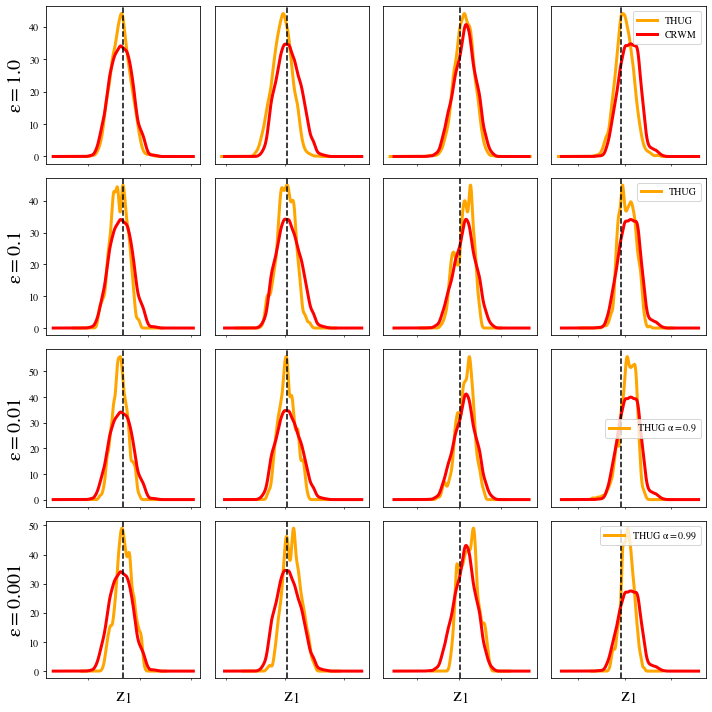

In [520]:
# Remember to transform the samples. At the moment they are on the u=[u1, u2] space, but we want them on
# the [z, u2] space really so that we can do a KDE plot on the histogram for z_true. Although one could also
# do it with u_true.
FROM = 10000
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), sharex='col')
# ϵ = 1.0
_ = pd.DataFrame(sHUG_1e0_5[FROM:, :4]).plot(kind='kde', subplots=True, ax=ax[0, :], lw=3, color='orange', legend=False)
_ = pd.DataFrame(sCRWM[FROM:, :4]).plot(kind='kde', subplots=True, ax=ax[0, :], lw=3, color='red', legend=False)
for i in range(4):
#     _ = ax[0, i].hist(sHUG_1e0_5[FROM:, i], bins=50)
    ax[0, i].axvline(u_true[i], c='k', ls='--')
    ax[0, 0].set_ylabel(r'$\mathregular{\epsilon=1.0}$', fontsize=20)
    ax[0, -1].legend(['THUG', 'CRWM'])
# ϵ = 0.1
_ = pd.DataFrame(sHUG_1em1_5[FROM:, :4]).plot(kind='kde', subplots=True, ax=ax[1, :], lw=3, color='orange', legend=False)
_ = pd.DataFrame(sCRWM[FROM:, :4]).plot(kind='kde', subplots=True, ax=ax[1, :], lw=3, color='red', legend=False)
for i in range(4):
#     _ = ax[1, i].hist(sHUG_1em1_5[FROM:, i], bins=50, density=True)
    ax[1, i].axvline(u_true[i], c='k', ls='--')
    ax[1, 0].set_ylabel(r'$\mathregular{\epsilon=0.1}$', fontsize=20)
    ax[1, -1].legend(['THUG'])

# ϵ = 0.01
_ = pd.DataFrame(sTHUG_1em2_5_09[FROM:, :4]).plot(kind='kde', subplots=True, ax=ax[2, :], lw=3, color='orange', legend=False)
_ = pd.DataFrame(sCRWM[FROM:, :4]).plot(kind='kde', subplots=True, ax=ax[2, :], lw=3, color='red', legend=False)
for i in range(4):
#     _ = ax[2, i].hist(sHUG_1em2_5[FROM:, i], bins=50)
#     _ = ax[2, i].hist(sTHUG_1em2_5_09[FROM:, i], bins=50)
    ax[2, i].axvline(u_true[i], c='k', ls='--')
    ax[2, 0].set_ylabel(r'$\mathregular{\epsilon=0.01}$', fontsize=20)
    ax[2, -1].legend([r'THUG $\mathregular{\alpha=0.9}$'])
# ϵ = 0.001
_ = pd.DataFrame(sTHUG_1em3_5_099[FROM:, :4]).plot(kind='kde', subplots=True, ax=ax[3, :], lw=3, color='orange', legend=False)
_ = pd.DataFrame(sCRWM[FROM:, :4]).plot(kind='kde', subplots=True, ax=ax[3, :], lw=3, color='red', legend=False)
for i in range(4):
#     _ = ax[3, i].hist(sHUG_1em3_5[FROM:, i], bins=50)
#     _ = ax[3, i].hist(sTHUG_1em3_5_09[FROM:, i], bins=50)
#     _ = ax[3, i].hist(sTHUG_1em3_5_099[FROM:, i], bins=50, density=True)
    ax[3, i].axvline(u_true[i], c='k', ls='--')
    ax[3, 0].set_ylabel(r'$\mathregular{\epsilon=0.001}$', fontsize=20)
    ax[3, -1].legend([r'THUG $\mathregular{\alpha=0.99}$'])

for i in range(4):
    ax[3, i].set_xlabel(r"$\mathregular{z_1}$", fontsize=20)
    ax[3, i].set_xticks([])
for i in range(4):
    for j in range(1, 4):
        ax[i, j].set_ylabel("")
        ax[i, j].set_yticks([])
plt.tight_layout()
# plt.savefig("figures/lv_thug_posteriors_various_epsilons.png")

#### minESS/runtime

In [465]:
from utils import ESS_univariate
from warnings import resetwarnings

In [466]:
resetwarnings()

### Computational Cost Experiment

Starting from convergence, I want to see if THUG is computationally cheaper than C-RWM.

In [585]:
def cc_experiment_thug(u0, δ, N, Bs, ϵs, α=0.0):
    """Computational Cost of THUG and C-RWM."""
    ESS_TABLE = zeros((len(ϵs), len(Bs)))
    AP_TABLE  = zeros((len(ϵs), len(Bs)))
    for ϵ_ix, ϵ in enumerate(ϵs):
        logηϵ = generate_logpi(ϵ)
        for B_ix, B in enumerate(Bs):
            start_time = time.time()
            s, a = HugTangentialMultivariate(u0, B*δ, B, N, α, q, logηϵ, J)
            runtime = time.time() - start_time
            ESS_TABLE[ϵ_ix, B_ix] = min(ESS_univariate(s)) / runtime
            AP_TABLE[ϵ_ix, B_ix]  = a.mean()
    return ESS_TABLE, AP_TABLE

def cc_experiment_crwm(u0, δ, N, Bs, tol=1e-11, rev_tol=1e-8):
    """Same as above but for C-RWM."""
    ESS_TABLE = zeros(len(Bs))
    AP_TABLE  = zeros(len(Bs))
    for B_ix, B in enumerate(Bs):
        start_time = time.time()
        s, e, a = zappa_sampling_storecomps_rattle(u0, manifold, N, δ*B, B, tol=tol, rev_tol=rev_tol)
        runtime = time.time() - start_time
        print("B={} time={} a={}".format(B, runtime, a.mean()))
        ESS_TABLE[B_ix] = min(ESS_univariate(s)) / runtime
        AP_TABLE[B_ix]  = a.mean()
    return ESS_TABLE, AP_TABLE

##### USING U0 WITH TRUE U1

In [606]:
OUT1, OUT2 = cc_experiment_thug(u0_with_u1true, 0.01, 1000, [1, 5, 10], [1.0, 0.1, 0.01, 0.001])

In [607]:
OUT3, OUT4 = cc_experiment_thug(u0_with_u1true, 0.01, 1000, [1, 5, 10], [1.0, 0.1, 0.01, 0.001], α=0.9)

In [608]:
OUT5, OUT6 = cc_experiment_thug(u0_with_u1true, 0.01, 1000, [1, 5, 10], [1.0, 0.1, 0.01, 0.001], α=0.99)

In [609]:
OUT7, OUT8 = cc_experiment_crwm(u0_with_u1true, 0.01, 1000, [1, 5, 10], tol=1e-12)

B=1 time=42.13290023803711 a=0.995
B=5 time=207.67396998405457 a=0.94
B=10 time=504.71916484832764 a=0.904


##### USING U0 FOUND BY OPTIMIZATION

In [611]:
OUT9, OUT10 = cc_experiment_thug(u0, 0.01, 1000, [1, 5, 10], [1.0, 0.1, 0.01, 0.001])

In [612]:
OUT11, OUT12 = cc_experiment_thug(u0, 0.01, 1000, [1, 5, 10], [1.0, 0.1, 0.01, 0.001], α=0.9)

In [613]:
OUT13, OUT14 = cc_experiment_thug(u0, 0.01, 1000, [1, 5, 10], [1.0, 0.1, 0.01, 0.001], α=0.99)

In [614]:
OUT15, OUT16 = cc_experiment_crwm(u0, 0.01, 1000, [1, 5, 10], tol=1e-12)

B=1 time=231.71947073936462 a=0.38
B=5 time=467.25784611701965 a=0.033
B=10 time=424.2762830257416 a=0.003


!!! NEED TO OUTPUT ALSO THE ACCEPTANCE PROBABILITY SO I CAN FILTER OUT WHEN IT BECOMES ZEROS

In [15]:
def show_only_positive_ap(cc, ap, ix):
    """USED FOR PLOTTING ONLY ESS WHERE WE HAD POSITIVE ACCEPTANCE PROBABILITY."""
    cc_copy = cc.copy()
    ap_copy = ap.copy()
    flag = ap_copy[:, ix] < 1e-8
    values = cc_copy[:, ix]
    values[flag] = np.nan
    return values

def show_only_positive_ap_crwm(out_cc, out_ap, ϵs, ix):
    """Same as above but for C-RWM."""
    cc_copy = deepcopy(out_cc.copy())
    ap_copy = deepcopy(out_ap.copy())
    flag = ap_copy < 1e-8
    cc_copy[flag] = np.nan
    return np.repeat(cc_copy[ix], len(ϵs))

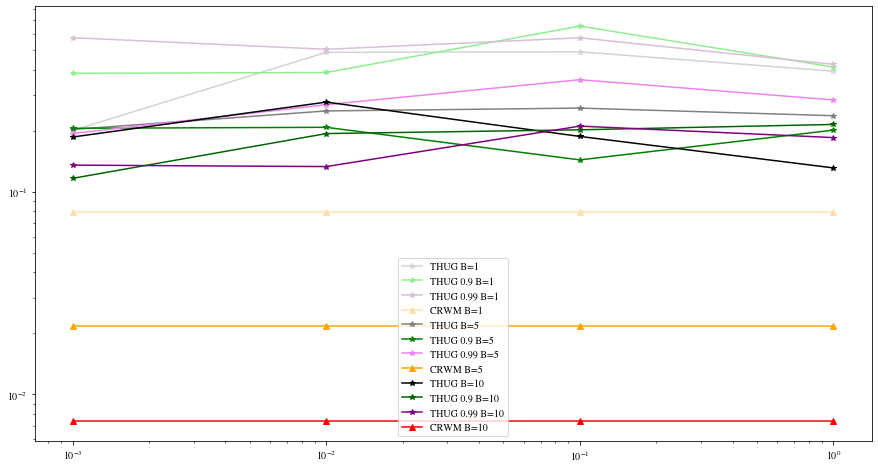

In [622]:
ϵs = [1.0, 0.1, 0.01, 0.001]
Bs = [1, 5, 10]
greys = ['lightgray', 'grey', 'black']
greens = ['lightgreen', 'green', 'darkgreen']
violets = ['thistle', 'violet', 'purple']
reds = ['navajowhite', 'orange', 'red']
# Plot computational costs
fig, ax = plt.subplots(figsize=(15, 8))
# alpha = 0.0
for i in range(len(Bs)):
    ax.plot(ϵs, show_only_positive_ap(OUT1, OUT2, i), color=greys[i], label='THUG B={}'.format(Bs[i]), marker='*')
    ax.plot(ϵs, show_only_positive_ap(OUT3, OUT4, i), color=greens[i], label='THUG 0.9 B={}'.format(Bs[i]), marker='*')
    ax.plot(ϵs, show_only_positive_ap(OUT5, OUT6, i), color=violets[i], label='THUG 0.99 B={}'.format(Bs[i]), marker='*')
    ax.plot(ϵs, show_only_positive_ap_crwm(OUT7, OUT8, ϵs, i), label='CRWM B={}'.format(Bs[i]), marker='^', color=reds[i])
ax.loglog()
plt.legend()
plt.show()

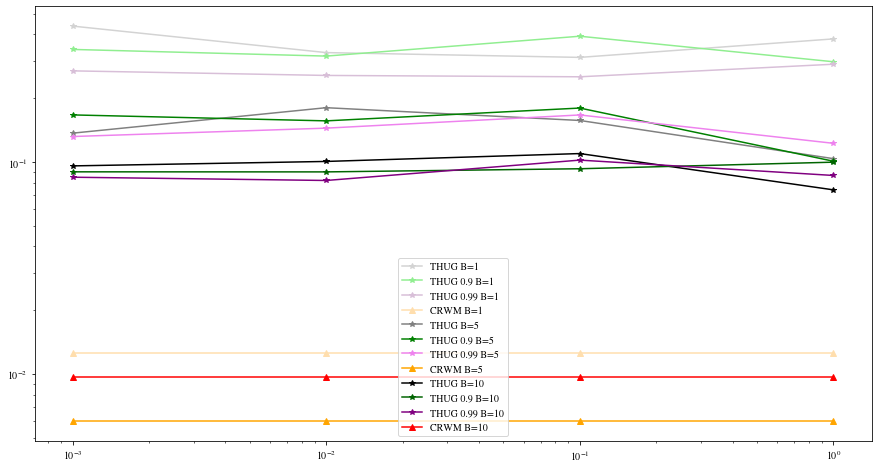

In [625]:
ϵs = [1.0, 0.1, 0.01, 0.001]
Bs = [1, 5, 10]
greys = ['lightgray', 'grey', 'black']
greens = ['lightgreen', 'green', 'darkgreen']
violets = ['thistle', 'violet', 'purple']
reds = ['navajowhite', 'orange', 'red']
# Plot computational costs
fig, ax = plt.subplots(figsize=(15, 8))
# alpha = 0.0
for i in range(len(Bs)):
    ax.plot(ϵs, show_only_positive_ap(OUT9, OUT10, i), color=greys[i], label='THUG B={}'.format(Bs[i]), marker='*')
    ax.plot(ϵs, show_only_positive_ap(OUT11, OUT12, i), color=greens[i], label='THUG 0.9 B={}'.format(Bs[i]), marker='*')
    ax.plot(ϵs, show_only_positive_ap(OUT13, OUT14, i), color=violets[i], label='THUG 0.99 B={}'.format(Bs[i]), marker='*')
    ax.plot(ϵs, show_only_positive_ap_crwm(OUT15, OUT16, ϵs, i), label='CRWM B={}'.format(Bs[i]), marker='^', color=reds[i])
ax.loglog()
plt.legend()
plt.show()

# Using Settings

In [17]:
import matplotlib.lines as mlines

In [7]:
# resetwarnings()

In [8]:
# def compute_arviz_miness_runtime(chains, times):
#     """Computes minESS/runtime. Expects chains=[samples, samples, ...] and times = [time, time, ...]."""
#     assert np.all([chain.shape == chains[0].shape for chain in chains]), "Chains must have same dimensions."
#     n_samples = len(chains[0])
#     stacked = np.vstack([chain.reshape(1, n_samples, -1) for chain in chains])
#     dataset = arviz.convert_to_dataset(stacked)
#     return min(np.array(arviz.ess(dataset).to_array()).flatten()) / np.mean(times)

In [7]:
def generate_settings(N, δ, Ns, Bs, ϵs, n_chains=4, u1_true=True, tol=1e-15, maxiter=5000):
    """Generates variables for the experiment."""
    manifold = LVManifold(Ns=Ns)
    u0s = zeros((n_chains, 2*Ns + 4))
    for i in range(n_chains):
        if u1_true:
            u0s[i, :] = manifold.find_point_on_manifold_given_u1true(maxiter=maxiter, tol=tol)
        else:
            u0s[i, :] = manifold.find_point_on_manifold(maxiter=maxiter, tol=tol)
    return {
        'N': N,
        'δ': δ,
        'Ns': Ns,
        'Bs': Bs,
        'ϵs': ϵs,
        'u0s': u0s,
        'manifold': manifold,
        'n_chains': n_chains
    }

In [8]:
SETTINGS100 = generate_settings(
    N=200, 
    δ=0.01, 
    Ns=100, 
    Bs=[1, 10, 20], 
    ϵs=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 
    u1_true=False,
    tol=1e-14,
    n_chains=4
)

In [9]:
# SETTINGS100_new = generate_settings(
#     N=100, 
#     δ=0.5, 
#     Ns=100, 
#     Bs=[1, 10, 20], 
#     ϵs=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 
#     u1_true=True,
#     tol=1e-14
# )

In [9]:
def cc_experiment_thug(settings, α=0.0):
    """Computational Cost of THUG and C-RWM."""
    ϵs, Bs = settings['ϵs'], settings['Bs']
    u0s = settings['u0s']
    δ = settings['δ']
    N = settings['N']
    q = settings['manifold'].q_dist
    J = settings['manifold'].J
    n_chains = settings['n_chains']
    ESS_TABLE = zeros((len(ϵs), len(Bs)))
    AP_TABLE  = zeros((len(ϵs), len(Bs)))
    for ϵ_ix, ϵ in enumerate(ϵs):
        logηϵ = settings['manifold'].generate_logpi(ϵ)
        for B_ix, B in enumerate(Bs):
            chains = []
            times  = []
            avg_ap = 0.0
            for chain_ix in range(n_chains):
                start_time = time.time()
                s, a = HugTangentialMultivariateSafe(u0s[chain_ix, :], B*δ, B, N, α, q, logηϵ, J)
                runtime = time.time() - start_time
                print("B={} time={} a={}".format(B, runtime, a.mean()))
                chains.append(s)
                times.append(runtime)
                avg_ap += (a.mean() / n_chains)
            ESS_TABLE[ϵ_ix, B_ix] = compute_arviz_miness_runtime(chains, times)
            AP_TABLE[ϵ_ix, B_ix]  = avg_ap
    return ESS_TABLE, AP_TABLE

def cc_experiment_crwm(settings, tol=1e-11, rev_tol=1e-8):
    """Same as above but for C-RWM."""
    Bs = settings['Bs']
    u0s = settings['u0s']
    manifold = settings['manifold']
    N = settings['N']
    δ = settings['δ']
    n_chains = settings['n_chains']
    ESS_TABLE = zeros(len(Bs))
    AP_TABLE  = zeros(len(Bs))
    for B_ix, B in enumerate(Bs):
        chains = []
        times  = []
        avg_ap = 0.0
        for chain_ix in range(n_chains):
            start_time = time.time()
            s, e, a = zappa_sampling_storecomps_rattle(u0s[chain_ix, :], manifold, N, δ*B, B, tol=tol, rev_tol=rev_tol)
            runtime = time.time() - start_time
            print("B={} time={} a={}".format(B, runtime, a.mean()))
            chains.append(s)
            times.append(runtime)
            avg_ap += (a.mean() / n_chains)
        ESS_TABLE[B_ix] = compute_arviz_miness_runtime(chains, times)
        AP_TABLE[B_ix]  = avg_ap
    return ESS_TABLE, AP_TABLE

In [10]:
O1, O2 = cc_experiment_thug(SETTINGS100, 0.0)

B=1 time=4.982898950576782 a=0.655
B=1 time=8.672307014465332 a=0.69
B=1 time=8.766931295394897 a=0.6
B=1 time=5.466220855712891 a=0.585
B=10 time=29.44235396385193 a=0.515
B=10 time=15.623735189437866 a=0.505
B=10 time=16.823177099227905 a=0.525
B=10 time=15.932811975479126 a=0.495
B=20 time=27.60176420211792 a=0.485
B=20 time=49.22216606140137 a=0.5
B=20 time=29.177570104599 a=0.51
B=20 time=32.28210377693176 a=0.47
B=1 time=6.146720886230469 a=0.525
B=1 time=6.630964279174805 a=0.455
B=1 time=5.130951166152954 a=0.46
B=1 time=4.815608263015747 a=0.395
B=10 time=33.07058310508728 a=0.59
B=10 time=22.096439838409424 a=0.495
B=10 time=18.575992822647095 a=0.465
B=10 time=16.842164993286133 a=0.445
B=20 time=26.881713151931763 a=0.445
B=20 time=35.74122166633606 a=0.485
B=20 time=24.981472969055176 a=0.495
B=20 time=25.144022941589355 a=0.435
B=1 time=4.804898977279663 a=0.105
B=1 time=5.046171188354492 a=0.095
B=1 time=4.808424949645996 a=0.1
B=1 time=4.810570001602173 a=0.115
B=10 tim

In [11]:
O3, O4 = cc_experiment_thug(SETTINGS100, 0.9)

B=1 time=5.273634195327759 a=0.63
B=1 time=5.068956136703491 a=0.67
B=1 time=4.82545804977417 a=0.605
B=1 time=5.833405256271362 a=0.585
B=10 time=14.329761028289795 a=0.34
B=10 time=26.571820974349976 a=0.32
B=10 time=14.320935726165771 a=0.325
B=10 time=25.2553129196167 a=0.235
B=20 time=25.275677919387817 a=0.39
B=20 time=24.699582815170288 a=0.325
B=20 time=35.35545587539673 a=0.285
B=20 time=24.346460103988647 a=0.26
B=1 time=4.808258056640625 a=0.59
B=1 time=4.955396890640259 a=0.62
B=1 time=10.799851894378662 a=0.535
B=1 time=4.7261340618133545 a=0.555
B=10 time=14.41301703453064 a=0.39
B=10 time=14.474496126174927 a=0.34
B=10 time=14.522173881530762 a=0.335
B=10 time=25.289725065231323 a=0.32
B=20 time=27.92332100868225 a=0.365
B=20 time=26.864853143692017 a=0.29
B=20 time=26.012489318847656 a=0.235
B=20 time=35.65489196777344 a=0.305
B=1 time=4.79234504699707 a=0.43
B=1 time=4.9784040451049805 a=0.475
B=1 time=4.913084983825684 a=0.41
B=1 time=4.89562201499939 a=0.445
B=10 tim

In [12]:
O5, O6 = cc_experiment_thug(SETTINGS100, 0.99)

B=1 time=5.082049131393433 a=0.66
B=1 time=4.765897989273071 a=0.64
B=1 time=4.873033046722412 a=0.645
B=1 time=4.799253940582275 a=0.575
B=10 time=16.688638925552368 a=0.44
B=10 time=25.449942111968994 a=0.345
B=10 time=14.126194953918457 a=0.245
B=10 time=14.572490930557251 a=0.29
B=20 time=24.787847995758057 a=0.29
B=20 time=24.713252067565918 a=0.265
B=20 time=24.903028964996338 a=0.23
B=20 time=37.36439394950867 a=0.215
B=1 time=5.402407884597778 a=0.645
B=1 time=5.4327733516693115 a=0.585
B=1 time=5.273711681365967 a=0.605
B=1 time=5.3539440631866455 a=0.615
B=10 time=14.188500881195068 a=0.36
B=10 time=14.674664974212646 a=0.315
B=10 time=14.4862802028656 a=0.245
B=10 time=14.447405099868774 a=0.255
B=20 time=37.76209807395935 a=0.285
B=20 time=25.17599606513977 a=0.26
B=20 time=24.734012842178345 a=0.24
B=20 time=25.592484712600708 a=0.275
B=1 time=5.0753161907196045 a=0.555
B=1 time=5.871057987213135 a=0.635
B=1 time=15.00111985206604 a=0.59
B=1 time=4.8955018520355225 a=0.575

In [13]:
O7, O8 = cc_experiment_crwm(SETTINGS100, tol=1e-11)

B=1 time=18.84973907470703 a=0.63
B=1 time=18.193825006484985 a=0.655
B=1 time=25.359930992126465 a=0.64
B=1 time=28.081562280654907 a=0.655
B=10 time=233.68424701690674 a=0.515
B=10 time=158.9300000667572 a=0.515
B=10 time=221.99089908599854 a=0.545
B=10 time=236.59208011627197 a=0.495
B=20 time=281.6195812225342 a=0.48
B=20 time=288.04181694984436 a=0.475
B=20 time=406.0023310184479 a=0.55
B=20 time=318.90921807289124 a=0.56


In [20]:
O7_1em12, O8_1em12 = cc_experiment_crwm(SETTINGS100, tol=1e-11, rev_tol=1e-11)

B=1 time=24.813613176345825 a=0.655
B=1 time=18.27516794204712 a=0.72
B=1 time=26.323943853378296 a=0.615
B=1 time=28.005775928497314 a=0.685
B=10 time=172.72553491592407 a=0.485
B=10 time=159.87774419784546 a=0.5
B=10 time=192.61282205581665 a=0.495
B=10 time=258.16016483306885 a=0.455
B=20 time=261.7607469558716 a=0.56
B=20 time=269.9868893623352 a=0.51
B=20 time=365.9685649871826 a=0.535
B=20 time=400.35249376296997 a=0.48


#### SMALLER STEP SIZE

In [208]:
O1new, O2new = cc_experiment_thug(SETTINGS100_new, 0.0)

In [212]:
O3new, O4new = cc_experiment_thug(SETTINGS100_new, 0.9)

In [213]:
O5new, O6new = cc_experiment_thug(SETTINGS100_new, 0.99)

In [217]:
O7new, O8new = cc_experiment_crwm(SETTINGS100_new, tol=1e-12, rev_tol=1e-12)

B=1 time=41.97546696662903 a=0.91
B=10 time=225.4380168914795 a=0.09
B=20 time=362.59835386276245 a=0.06


In [45]:
import matplotlib.lines as mlines
from matplotlib import rc

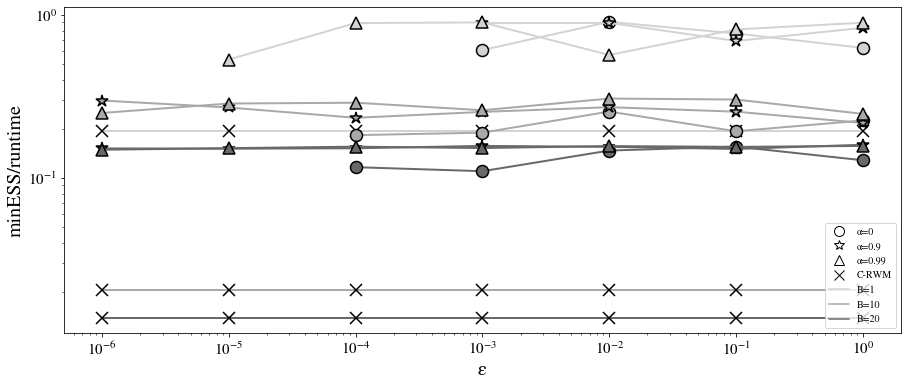

In [18]:
ϵs_100 = SETTINGS100['ϵs']
Bs_100 = SETTINGS100['Bs']
greys = ['lightgray', 'darkgrey', 'dimgrey']
greens = ['lightgreen', 'green', 'darkgreen']
violets = ['thistle', 'violet', 'purple']
reds = ['navajowhite', 'orange', 'red']
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2
rc('font',**{'family':'STIXGeneral'})
# Plot computational costs
fig, ax = plt.subplots(figsize=(15, 6))
# alpha = 0.0
for i in range(len(Bs_100)):
    ax.plot(ϵs_100, show_only_positive_ap(O1, O2, i), color=greys[i], marker='o', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap(O3, O4, i), color=greys[i], marker='*', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap(O5, O6, i), color=greys[i], marker='^', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap_crwm(O7, O8, ϵs_100, i), marker='x', color=greys[i], markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
#     ax.plot(ϵs_100, show_only_positive_ap_crwm(_257[0], _257[1], ϵs_100, i), marker='x', color=greys[i], markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')

# Legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
cross    = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='x', linestyle='None', markersize=10, label='C-RWM')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B={}'.format(Bs_100[0]))
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B={}'.format(Bs_100[1]))
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B={}'.format(Bs_100[2]))
ax.legend(handles=[circle, star, triangle, cross, lightline, mediumline, darkline], loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$\mathregular{\epsilon}$", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
# plt.savefig('figures/lv_computational_cost_100.png')
plt.show()

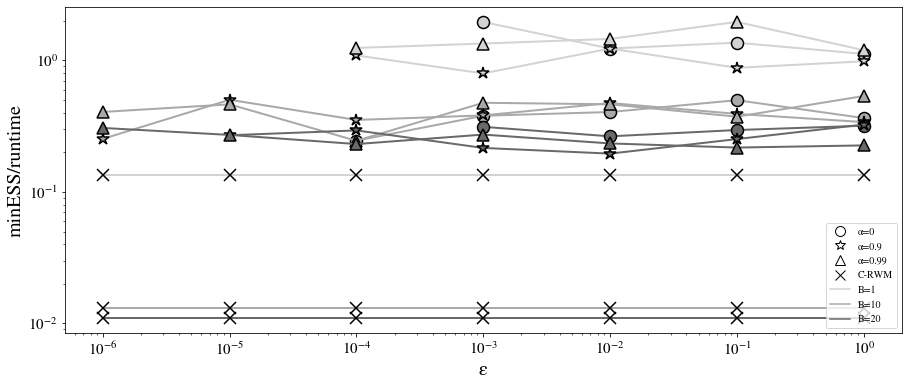

In [206]:
ϵs_100 = SETTINGS100['ϵs']
Bs_100 = SETTINGS100['Bs']
greys = ['lightgray', 'darkgrey', 'dimgrey']
greens = ['lightgreen', 'green', 'darkgreen']
violets = ['thistle', 'violet', 'purple']
reds = ['navajowhite', 'orange', 'red']
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2
rc('font',**{'family':'STIXGeneral'})
# Plot computational costs
fig, ax = plt.subplots(figsize=(15, 6))
# alpha = 0.0
for i in range(len(Bs_100)):
    ax.plot(ϵs_100, show_only_positive_ap(O1, O2, i), color=greys[i], marker='o', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap(O3, O4, i), color=greys[i], marker='*', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap(O5, O6, i), color=greys[i], marker='^', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_100, show_only_positive_ap_crwm(O7, O8, ϵs_100, i), marker='x', color=greys[i], markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
# Legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
cross    = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='x', linestyle='None', markersize=10, label='C-RWM')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B={}'.format(Bs_100[0]))
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B={}'.format(Bs_100[1]))
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B={}'.format(Bs_100[2]))
ax.legend(handles=[circle, star, triangle, cross, lightline, mediumline, darkline], loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$\mathregular{\epsilon}$", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
# plt.savefig('figures/lv_computational_cost_100.png')
plt.show()

# 120

In [44]:
SETTINGS120 = generate_settings(
    N=200, 
    δ=0.01,
    Ns=120, 
    Bs=[1, 10, 20], 
    ϵs=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 
    u1_true=False,
    tol=1e-14,
    n_chains=4
)

In [45]:
O7_120, O8_120 = cc_experiment_crwm(SETTINGS120, tol=1e-11, rev_tol=1e-11)

B=1 time=21.7250816822052 a=0.725
B=1 time=30.176949977874756 a=0.635
B=1 time=29.02499508857727 a=0.6
B=1 time=74.81748700141907 a=0.0
B=10 time=213.7419571876526 a=0.5
B=10 time=231.11781072616577 a=0.545
B=10 time=212.57090616226196 a=0.565
B=10 time=69.03816413879395 a=0.0
B=20 time=409.40584683418274 a=0.48
B=20 time=485.9107460975647 a=0.48
B=20 time=467.8759732246399 a=0.485
B=20 time=70.53127694129944 a=0.0


In [46]:
O1_120, O2_120 = cc_experiment_thug(SETTINGS120, 0.0)

B=1 time=6.734117746353149 a=0.595
B=1 time=6.679836988449097 a=0.55
B=1 time=6.541531085968018 a=0.6
B=1 time=6.042707920074463 a=0.46
B=10 time=19.030061721801758 a=0.425
B=10 time=15.132596015930176 a=0.335
B=10 time=20.35660481452942 a=0.515
B=10 time=15.72331714630127 a=0.15
B=20 time=34.18264293670654 a=0.455
B=20 time=30.159321069717407 a=0.46
B=20 time=32.81982898712158 a=0.435
B=20 time=24.87251305580139 a=0.2
B=1 time=6.688805818557739 a=0.56
B=1 time=6.434142827987671 a=0.425
B=1 time=6.537933826446533 a=0.505
B=1 time=5.8831117153167725 a=0.27
B=10 time=18.898907899856567 a=0.48
B=10 time=17.442596197128296 a=0.34
B=10 time=18.090174913406372 a=0.37
B=10 time=10.140480995178223 a=0.17
B=20 time=41.69087100028992 a=0.45
B=20 time=28.147167921066284 a=0.365
B=20 time=33.52038097381592 a=0.495
B=20 time=14.950129747390747 a=0.14
B=1 time=7.014118909835815 a=0.155
B=1 time=8.626101970672607 a=0.14
B=1 time=7.346239805221558 a=0.08
B=1 time=6.00099515914917 a=0.03
B=10 time=24.3

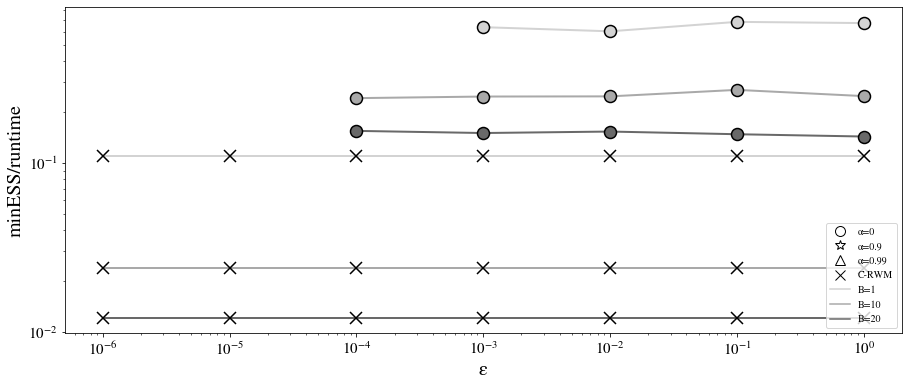

In [47]:
ϵs_120 = SETTINGS120['ϵs']
Bs_120 = SETTINGS120['Bs']
greys = ['lightgray', 'darkgrey', 'dimgrey']
greens = ['lightgreen', 'green', 'darkgreen']
violets = ['thistle', 'violet', 'purple']
reds = ['navajowhite', 'orange', 'red']
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2
rc('font',**{'family':'STIXGeneral'})
# Plot computational costs
fig, ax = plt.subplots(figsize=(15, 6))
# alpha = 0.0
for i in range(len(Bs_100)):
    ax.plot(ϵs_120, show_only_positive_ap(O1_120, O2_120, i), color=greys[i], marker='o', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
#     ax.plot(ϵs_100, show_only_positive_ap(O3, O4, i), color=greys[i], marker='*', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
#     ax.plot(ϵs_100, show_only_positive_ap(O5, O6, i), color=greys[i], marker='^', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_120, show_only_positive_ap_crwm(O7_120, O8_120, ϵs_120, i), marker='x', color=greys[i], markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
#     ax.plot(ϵs_100, show_only_positive_ap_crwm(_257[0], _257[1], ϵs_100, i), marker='x', color=greys[i], markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')

# Legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
cross    = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='x', linestyle='None', markersize=10, label='C-RWM')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B={}'.format(Bs_120[0]))
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B={}'.format(Bs_120[1]))
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B={}'.format(Bs_120[2]))
ax.legend(handles=[circle, star, triangle, cross, lightline, mediumline, darkline], loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$\mathregular{\epsilon}$", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
# plt.savefig('figures/lv_computational_cost_100.png')
plt.show()

# 200

In [22]:
SETTINGS200 = generate_settings(
    N=200, 
    δ=0.01,
    Ns=200, 
    Bs=[1, 10, 20], 
    ϵs=[1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 
    u1_true=False,
    tol=1e-13,
    n_chains=4
)

KeyboardInterrupt: 

In [189]:
O9, O10 = cc_experiment_thug(SETTINGS200, 0.0)

In [190]:
O11, O12 = cc_experiment_thug(SETTINGS200, 0.9)

In [191]:
O13, O14 = cc_experiment_thug(SETTINGS200, 0.99)

In [187]:
O15, O16 = cc_experiment_crwm(SETTINGS200, tol=1e-11)

B=1 time=13.503690004348755 a=1.0
B=10 time=121.710440158844 a=0.69
B=20 time=285.4747169017792 a=0.47


In [196]:
O17, O18 = cc_experiment_crwm(SETTINGS200, tol=0.2e-11)

B=1 time=37.89690804481506 a=1.0
B=10 time=380.7576689720154 a=0.72
B=20 time=805.223620891571 a=0.46


In [204]:
O19, O20 = cc_experiment_crwm(SETTINGS200, tol=1e-11, rev_tol=1e-11)

B=1 time=14.456012964248657 a=1.0
B=10 time=128.87804198265076 a=0.73
B=20 time=254.70561981201172 a=0.54


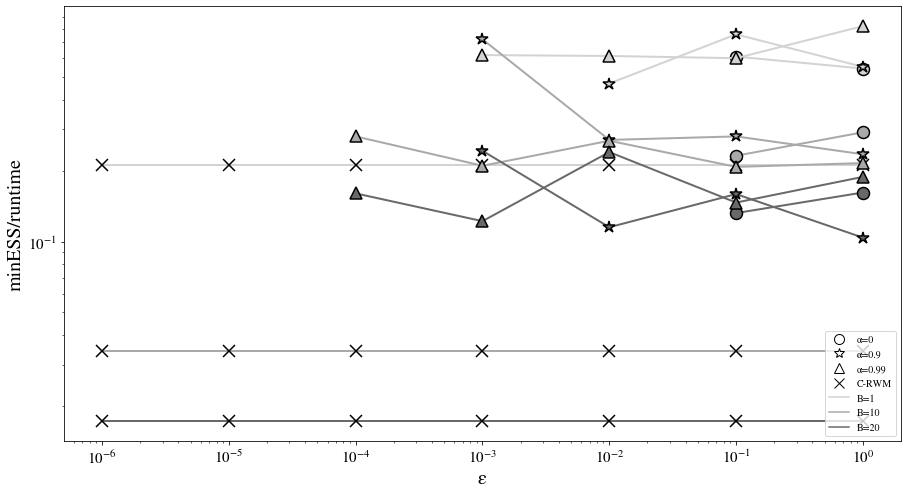

In [203]:
ϵs_200 = SETTINGS200['ϵs']
Bs_200 = SETTINGS200['Bs']
greys = ['lightgray', 'darkgrey', 'dimgrey']
greens = ['lightgreen', 'green', 'darkgreen']
violets = ['thistle', 'violet', 'purple']
reds = ['navajowhite', 'orange', 'red']
MARKERSIZE = 12
LINEWIDTH  = 2
MARKEREDGEWIDTH = 1.5
CRWM_LINEWIDTH=2
rc('font',**{'family':'STIXGeneral'})
# Plot computational costs
fig, ax = plt.subplots(figsize=(15, 8))
# alpha = 0.0
for i in range(len(Bs_200)):
    ax.plot(ϵs_200, show_only_positive_ap(O9, O10, i), color=greys[i], marker='o', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_200, show_only_positive_ap(O11, O12, i), color=greys[i], marker='*', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_200, show_only_positive_ap(O13, O14, i), color=greys[i], marker='^', markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
    ax.plot(ϵs_200, show_only_positive_ap_crwm(O19, O20, ϵs_200, i), marker='x', color=greys[i], markersize=MARKERSIZE, markeredgewidth=MARKEREDGEWIDTH, lw=LINEWIDTH, markeredgecolor='k')
# Legend
triangle = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='^', linestyle='None', markersize=10, label='α=0.99')
star     = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='*', linestyle='None', markersize=10, label='α=0.9')
circle   = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='o', linestyle='None', markersize=10, label='α=0')
cross    = mlines.Line2D([], [], markeredgecolor='k', color='white', marker='x', linestyle='None', markersize=10, label='C-RWM')
lightline  = mlines.Line2D([], [], color='lightgray', linestyle='-', label='B={}'.format(Bs_200[0]))
mediumline = mlines.Line2D([], [], color='darkgrey', linestyle='-', label='B={}'.format(Bs_200[1]))
darkline   = mlines.Line2D([], [], color='dimgrey', linestyle='-', label='B={}'.format(Bs_200[2]))
ax.legend(handles=[circle, star, triangle, cross, lightline, mediumline, darkline], loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r"$\mathregular{\epsilon}$", fontsize=20)
ax.set_ylabel("minESS/runtime", fontsize=20)
ax.loglog()
plt.show()

In [ ]:
def cc_experiment_thug(u0, δ, N, Bs, ϵs, α=0.0):
    """Computational Cost of THUG and C-RWM."""
    ESS_TABLE = zeros((len(ϵs), len(Bs)))
    AP_TABLE  = zeros((len(ϵs), len(Bs)))
    for ϵ_ix, ϵ in enumerate(ϵs):
        logηϵ = generate_logpi(ϵ)
        for B_ix, B in enumerate(Bs):
            start_time = time.time()
            s, a = HugTangentialMultivariate(u0, B*δ, B, N, α, q, logηϵ, J)
            runtime = time.time() - start_time
            ESS_TABLE[ϵ_ix, B_ix] = min(ESS_univariate(s)) / runtime
            AP_TABLE[ϵ_ix, B_ix]  = a.mean()
    return ESS_TABLE, AP_TABLE

def cc_experiment_crwm(u0, δ, N, Bs, tol=1e-11, rev_tol=1e-8):
    """Same as above but for C-RWM."""
    ESS_TABLE = zeros(len(Bs))
    AP_TABLE  = zeros(len(Bs))
    for B_ix, B in enumerate(Bs):
        start_time = time.time()
        s, e, a = zappa_sampling_storecomps_rattle(u0, manifold, N, δ*B, B, tol=tol, rev_tol=rev_tol)
        runtime = time.time() - start_time
        print("B={} time={} a={}".format(B, runtime, a.mean()))
        ESS_TABLE[B_ix] = min(ESS_univariate(s)) / runtime
        AP_TABLE[B_ix]  = a.mean()
    return ESS_TABLE, AP_TABLE